# Car sales

## Introduction

The present project seeks to provide a machine learning model to determine market value of cars for Rusty Bargain company. Using features such as the car's brand, mileage, and year, the model will predict the price based on historical data.


## Data Preprocess

### Objective

The historical database of car prices has been provided, with information that will be used for model training. The provided data contains the following columns:

- DateCrawled: date profile has been downloaded
- VehicleType: vehicle body type
- RegistrationYear: vehicle registration
- Gearbox: gearbox tpe
- Power: power in hp
- Model: car name
- Mileage: in kilometers
- RegistrationMonth: registration on the platform
- Brand: vehicle brand
- NotRepaired: whether the car is repaired
- DateCreated: profile creation date
- NumberOfPictures: number of vehicle pictures
- PostalCode: region of profile owner
- LastSeen: date of the last activity by user

### Code

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from IPython.display import display
import sklearn.metrics as metrics

import seaborn as sns
from joblib import dump


if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [131]:
path_array = ['', '/', '/datasets/', './datasets/', '../datasets/']
CSVPATH = None

for i in path_array:
    try:
        pd.read_csv(i + 'car_data.csv', nrows=1)
        CSVPATH = i
        break
    except:
        pass

if CSVPATH:
    print('Path found is', 'current folder' if CSVPATH == '' else CSVPATH)
else:
    print('No path found')

Path found is ../datasets/


In [132]:
date_cols = ['DateCrawled', 'DateCreated', 'LastSeen']
df = pd.read_csv(CSVPATH + 'car_data.csv', nrows=10)

def optimize_types(df):
    df_dtypes = df.dtypes
    df_types = [i.name for i in df_dtypes.values]
    df_types = dict(zip(df.columns, df_types))
    return df_types

int_columns = df.select_dtypes(include=['int64']).columns

for col in int_columns:
    df[col] = pd.to_numeric(df[col], downcast = 'integer')
    
df_types = optimize_types(df)


In [133]:
df = pd.read_csv(CSVPATH + 'car_data.csv',
                 dtype=df_types)

for col in date_cols:
    df[col] = pd.to_datetime(df[col], format='%d/%m/%Y %H:%M').dt.normalize()

print(f'The dataframe has {df.shape[0]} rows and {df.shape[1]} columns')
df.head()

The dataframe has 354369 rows and 16 columns


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07
1,2016-03-24,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07
2,2016-03-14,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05
3,2016-03-17,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17
4,2016-03-31,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06


In [134]:
df_initial_size = df.shape[0]

In [135]:
df.dtypes

DateCrawled          datetime64[ns]
Price                         int16
VehicleType                  object
RegistrationYear              int16
Gearbox                      object
Power                         int16
Model                        object
Mileage                       int32
RegistrationMonth              int8
FuelType                     object
Brand                        object
NotRepaired                  object
DateCreated          datetime64[ns]
NumberOfPictures               int8
PostalCode                    int32
LastSeen             datetime64[ns]
dtype: object

In [136]:
df['NotRepaired'] = df['NotRepaired'].transform(lambda x: 0 if x == 'yes' else 1 if x == 'no' else np.nan)
df.rename(columns={'NotRepaired': 'Repaired'}, inplace=True)


In [137]:
(df.isna().sum()/df.shape[0]).sort_values(ascending=False).head(6)

Repaired       0.200791
VehicleType    0.105794
FuelType       0.092827
Gearbox        0.055967
Model          0.055606
DateCrawled    0.000000
dtype: float64

In [138]:
df[['Model', 'RegistrationYear', 'VehicleType', 'FuelType', 'Gearbox']].groupby('Model')['RegistrationYear'].unique()

Model
100        [1985, 1994, 1992, 1990, 1993, 1996, 1984, 201...
145        [2000, 1998, 1999, 1997, 1996, 2018, 2016, 199...
147        [2007, 2006, 2008, 2002, 2003, 2001, 2005, 200...
156        [2000, 2002, 1999, 2001, 2003, 2005, 2004, 201...
159        [2006, 2007, 2010, 2005, 2011, 2008, 2009, 201...
                                 ...                        
yaris      [2002, 2003, 2018, 2001, 2008, 2007, 2000, 200...
yeti        [2013, 2012, 2015, 2009, 2011, 2010, 2014, 2017]
ypsilon    [2000, 2017, 2002, 1995, 1996, 2007, 2004, 201...
z_reihe    [2004, 2007, 1996, 2006, 1998, 2003, 1997, 200...
zafira     [2017, 1999, 2011, 2000, 2005, 2001, 2003, 200...
Name: RegistrationYear, Length: 250, dtype: object

In [139]:
missing_cols = ['VehicleType', 'FuelType', 'Gearbox', 'Model']
df[missing_cols] = df[missing_cols].fillna('unknown', axis=1)

In [140]:
(df.isna().sum()/df.shape[0]).sort_values(ascending=False).head(6)

Repaired            0.200791
DateCrawled         0.000000
Price               0.000000
VehicleType         0.000000
RegistrationYear    0.000000
Gearbox             0.000000
dtype: float64

In [141]:
df.describe().round(2)

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,Repaired,NumberOfPictures,PostalCode
count,354369.00,354369.00,354369.00,354369.00,354369.00,283215.00,354369.0,354369.00
mean,4416.66,2004.23,110.09,128211.17,5.71,0.87,0.0,50508.69
std,4514.16,90.23,189.85,37905.34,3.73,0.33,0.0,25783.10
min,0.00,1000.00,0.00,5000.00,0.00,0.00,0.0,1067.00
25%,1050.00,1999.00,69.00,125000.00,3.00,1.00,0.0,30165.00
50%,2700.00,2003.00,105.00,150000.00,6.00,1.00,0.0,49413.00
75%,6400.00,2008.00,143.00,150000.00,9.00,1.00,0.0,71083.00
max,20000.00,9999.00,20000.00,150000.00,12.00,1.00,0.0,99998.00


In [142]:
df.drop(['NumberOfPictures', 'RegistrationMonth'], axis=1, inplace=True)

In [143]:
invalid_zeros = ['Price', 'Power']

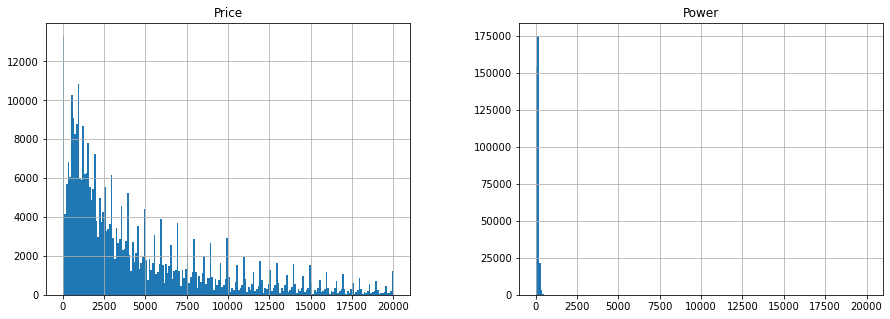

In [144]:
df[invalid_zeros].hist(bins=200, figsize=(15,5))
plt.show()

*Graph Analysis*

Price and power of cars can not be equal to zero. The histograms for these columns show that there are errors in the data. The minimum price for a car will be considered as 200 USD. As for power, a quick research online shows that the historical lowest power for a car is 13 hp, while the maximum is 1500 hp. Further analysis could be made to find better values if needed, by checking the car model.

In [145]:
df = df[df['Price'] >= 200].reset_index(drop=True)
df = df[df['Power'] <= 1500].reset_index(drop=True)
df = df[13 <= df['Power']].reset_index(drop=True)

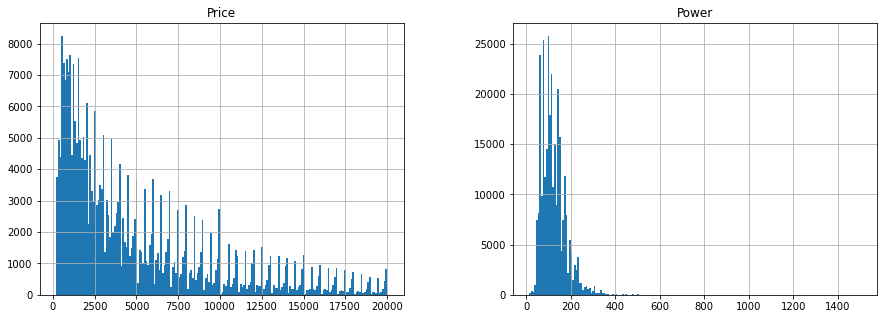

In [146]:
df[invalid_zeros].hist(bins=200, figsize=(15,5))
plt.show()

In [147]:
print(f'{df.shape[0]/df_initial_size:.2%}')

85.46%


In [148]:
for brand in df['Brand'].unique():
    df.loc[ df['Brand'] == brand ] = df[ df['Brand'] == brand ].sort_values('Price').fillna(method='bfill')

In [149]:
df['Repaired'].isna().sum()

6

In [150]:
df.fillna(1.0, inplace=True)

In [151]:
clean_df = df.copy()

### Results

The preprocessing stage made many issues with the data apparent. More than 20% of the data entries have missing values, most of them for the information of whether the car is repaired or not. All of the missing data is missing completely at random. This could be related to sellers not being sure what is considered "repaired", as it is not very specific about the car conditions. Replacing it with a car condition could be more useful.

All of the entries had no pictures, and this information was deleted. In addition, registration months cointained observations with 0 values which do not correspond to a month and it is not a relevant information for the model development - the year of registration should be enough. Therefore, the registration month was also removed. As for numerical values, Price and Power columns had artifacts. Prices lesser than 200 dollars were not considered, as it isn't a real price even for a faulty car. Power values lesser than 13 hp or higher than 1500 hp were not considered as well, as these are not valid values for a car. 

Lastly, the missing data regarding gearbox, vehicle types, fuel type and car models were filled in with 'unknown'. After trying different approcheas to fill in information based on car brand and model, it was still not possible to achieve a good result. The main reason for that is because observations of the same car model can still have many different registered values for vehicle type, fuel type and even using the registration year is not enough to fill gearbox.



## Exploratory Data Analysis

### Objective

A short EDA section will be performed to further prepare data and columns for model training. We will further select necessary data for prediction and maybe filter some more observations.

### Code

In [152]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
0,2016-03-24,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,0.0,2016-03-24,66954,2016-04-07
1,2016-03-14,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,1.0,2016-03-14,90480,2016-04-05
2,2016-03-17,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,1.0,2016-03-17,91074,2016-03-17
3,2016-03-31,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,1.0,2016-03-31,60437,2016-04-06
4,2016-04-04,650,sedan,1995,manual,102,3er,150000,petrol,bmw,0.0,2016-04-04,33775,2016-04-06


In [153]:
df.drop(['DateCrawled', 'LastSeen', 'DateCreated', 'PostalCode', 'FuelType', 'Gearbox'], axis=1, inplace=True)

In [154]:
cat_cols = ['VehicleType', 'Model','Brand']

In [155]:
df.head()

,Price,VehicleType,RegistrationYear,Power,Model,Mileage,Brand,Repaired
0,18300,coupe,2011,190,unknown,125000,audi,0.0
1,9800,suv,2004,163,grand,125000,jeep,1.0
2,1500,small,2001,75,golf,150000,volkswagen,1.0
3,3600,small,2008,69,fabia,90000,skoda,1.0
4,650,sedan,1995,102,3er,150000,bmw,0.0


In [156]:
df['UntrustedData'] = ( df['Power'] < 78 ).astype('int') * 10

In [157]:
def split_df(df, train=3, valid=1, test=1):
    split_size = int(df.shape[0]/(train+valid+test))
    train_df = df[0 : train*split_size].reset_index(drop=True)
    valid_df = df[train*split_size+1 : (train+valid)*split_size].reset_index(drop=True)
    test_df = df[(train+valid)*split_size+1 : df.shape[0]].reset_index(drop=True)
    return train_df, valid_df, test_df

train_df, valid_df, test_df = split_df(df)

print('Splitting dataframes in proportion: 3, 1, 1')
print('Train dataframe size:', train_df.shape[0])
print('Validation dataframe size:', valid_df.shape[0])
print('Test dataframe size:', test_df.shape[0])

Splitting dataframes in proportion: 3, 1, 1
Train dataframe size: 181698
Validation dataframe size: 60565
Test dataframe size: 60567


In [158]:
def train_ohe_scaler(train_df, ohe_encoder=None, std_scaler=None):
    """
    Apply OHE and Scale on a df of strings and numbers. Object columns are automatically found and OHE is applied to them. 
    After that, numbers are scaled. The encoder and the scaler can be manually passed, otherwise they are created.

    Output is feature-prepared DataFrame, OneHotEncoder object and StandardScaler object.
    obs: DataFrame has no object columns and the encoded objects are on the rightmost columns.
    """
    ret = 0
    df = train_df
    # create encoders if None were passed
    if ohe_encoder == None:
        ohe_encoder = OneHotEncoder(handle_unknown='error', drop='first')
        ret+=1
    if std_scaler == None:
        std_scaler = StandardScaler()
        ret+=2

    # Find object and boolean variables
    object_cols = []
    bool_cols = []
    for col, dtype in zip(df.columns, df.dtypes):
        if dtype == 'object':
            object_cols.append(col)
        if dtype in ['bool']:
            bool_cols.append(col)

    # Train ohe_encoder on object columns
    ohe_encoder.fit(df[object_cols])

    # backup_boolean_cols
    df_bool = df[bool_cols]
    df = df.drop(bool_cols, axis=1)

    # Leave df with numerical columns only by dropping objects and adding ohe
    df = df.drop(object_cols, axis=1)

    # Train scaler
    std_scaler.fit(df)
    
    return ohe_encoder, std_scaler

def encode_scale(df, ohe_encoder, std_scaler):
    
    # Find object and boolean variables
    object_cols = []
    bool_cols = []
    for col, dtype in zip(df.columns, df.dtypes):
        if dtype == 'object':
            object_cols.append(col)
        if dtype in ['bool']:
            bool_cols.append(col)
            
    # Transform and create encoded df
    ohe_encoded = pd.DataFrame(
                data=ohe_encoder.transform(df[object_cols]).toarray(), 
                columns=ohe_encoder.get_feature_names(object_cols)
    ).astype('bool')
            
    # backup_boolean_cols as integer
    df_bool = df[bool_cols].astype('int')
    df = df.drop(bool_cols, axis=1)

    # Leave df with numerical columns only by dropping objects and adding ohe
    df = df.drop(object_cols, axis=1)
    
    # Transform and create scaled df
    scaler = pd.DataFrame(
        std_scaler.transform(df), 
        columns=df.columns
        )
    
    
    df = df_bool.join(scaler).join(ohe_encoded)

    return df

encoder, scaler = train_ohe_scaler(df)

In [159]:
ohe_encoder, std_scaler = train_ohe_scaler(train_df)

train_df = encode_scale(train_df, ohe_encoder, std_scaler)
test_df = encode_scale(test_df, ohe_encoder, std_scaler)
valid_df = encode_scale(valid_df, ohe_encoder, std_scaler)

display(train_df.head())
display(test_df.head())
display(valid_df.head())

,Price,RegistrationYear,Power,Mileage,Repaired,UntrustedData,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo
0,2.916636,0.243547,1.188076,-0.091792,-2.728298,-0.579490,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1.068323,0.014540,0.721558,-0.091792,0.366529,-0.579490,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,-0.736500,-0.083605,-0.798942,0.590195,0.366529,1.725656,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,-0.279858,0.145401,-0.902612,-1.046573,0.366529,1.725656,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
4,-0.921331,-0.279897,-0.332425,0.590195,-2.728298,-0.579490,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


,Price,RegistrationYear,Power,Mileage,Repaired,UntrustedData,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo
0,-0.649521,0.145401,-0.453374,0.590195,-2.728298,-0.57949,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,-0.301603,0.145401,-0.211476,0.590195,0.366529,-0.57949,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,2.525229,0.374408,-0.090527,-2.956134,0.366529,-0.57949,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,0.676916,0.014540,0.842507,-0.773778,0.366529,-0.57949,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,-0.236368,-0.018175,0.168649,0.590195,0.366529,-0.57949,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


,Price,RegistrationYear,Power,Mileage,Repaired,UntrustedData,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo
0,0.198529,0.079971,0.375990,0.590195,0.366529,-0.57949,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0.349656,0.047256,-0.280589,-0.091792,0.366529,-0.57949,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,0.970471,-0.050890,1.429973,-1.046573,0.366529,-0.57949,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,0.020221,0.112686,0.496939,0.590195,0.366529,-0.57949,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,-0.877842,-0.149036,-0.574323,0.590195,0.366529,-0.57949,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Results

## Model Training

### Objective

In this section a model for predicting prices will be trained by using the data provided. We will try different types of approaches and tuning the model parameters to find the best one.

### Code

In [160]:
def target_features(df, tar_col, remove=[]):
    target = df[tar_col]
    remove.append(tar_col)
    features = df[[x for x in train_df.columns.values if x not in remove]]
    return target, features

train_target, train_features = target_features(train_df, 'Price')
valid_target, valid_features = target_features(valid_df, 'Price')
test_target, test_features = target_features(test_df, 'Price')


In [161]:
def report(target, features=None, predictions=None, model=None, predictions_proba=None, classifier=True, scorer=None, cv=3):
    """
    Prints a report of the model's performance. If regressor, add classifier=False
    """
    flag = 0
    if model != None:
        if predictions is not None:
            warnings.warn('Both model and predictions were passed. Ignoring model.')
        else:
            if features is None:
                raise ValueError('Features must be passed if model is passed.')
            predictions = model.predict(features)
            if classifier == True:
                predictions_proba = model.predict_proba(features)
    if predictions is not None:
        if classifier == True:
            print(f'Accuracy: {metrics.accuracy_score(target,predictions):.2%}') 
            print(f'Recall: {metrics.recall_score(target,predictions):.2%}')
            print(f'Precision: {metrics.precision_score(target,predictions):.2%}')
            print(f'F1 Score: {metrics.f1_score(target,predictions):.2%}')
        elif classifier == False:
            print(f'Mean Absolute Error: {metrics.mean_absolute_error(target,predictions):.2f}')
            print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(target,predictions)):.2f}') 
            print(f'R2 Score: {metrics.r2_score(target,predictions):.2f}')
            print(f'Predictions mean value: {np.mean(predictions):.2f} (Target mean is {np.mean(target):.2f})')
            print(f'Predictions median value: {np.median(predictions):.2f} (Target median is {np.median(target):.2f})')
            if scorer != None:
                print(f'Cross validation results (Root Mean Square Error):')
                print(np.sqrt(cross_val_score(model, features, target, cv=cv, scoring=scorer) * (-1)))
            target = pd.Series(target).reset_index(drop=True).sort_values()
            predictions = pd.Series(predictions)
            predictions = predictions.iloc[target.index].reset_index(drop=True)
            target = target.reset_index(drop=True)
            plt.plot(predictions, label='Predicted')
            plt.plot(target, label='Actual', color='orange')
            plt.legend(['Predicted', 'Actual'])
            plt.xlabel('Sample Number')
            plt.show()
    if predictions_proba is not None:
        fpr, tpr, thresholds = metrics.roc_curve(target, predictions_proba[:,1])
        print(f'AUC-ROC: {metrics.roc_auc_score(target,predictions_proba[:,1]):.2%}')
        flag = 1
    if flag == 1:
        return fpr, tpr, thresholds, predictions
    else:
        return predictions

In [162]:
scorer = metrics.make_scorer(metrics.mean_squared_error, greater_is_better=False)

In [163]:
linear = LinearRegression()

In [164]:
%%time
linear.fit(train_features, train_target)

CPU times: total: 9.23 s
Wall time: 4.78 s


LinearRegression()

Mean Absolute Error: 0.47
Root Mean Squared Error: 0.66
R2 Score: 0.56
Predictions mean value: -0.00 (Target mean is -0.01)
Predictions median value: -0.07 (Target median is -0.37)
Cross validation results (Root Mean Square Error):
[0.6602187  0.66405092 0.67056379]


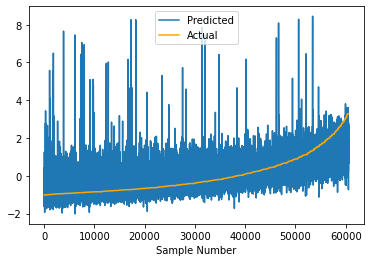

0       -1.384837
1       -1.321697
2       -0.892699
3       -1.621574
4       -1.141280
           ...   
60560    1.832952
60561    2.228583
60562    2.722167
60563    0.628193
60564    1.770076
Length: 60565, dtype: float64

In [165]:
report(valid_target, valid_features, model=linear, classifier=False, scorer=scorer)

In [166]:
forest = RandomForestRegressor(n_estimators=10, random_state=42)

In [167]:
%%time
forest.fit(train_features, train_target)

CPU times: total: 28.4 s
Wall time: 29.3 s


RandomForestRegressor(n_estimators=10, random_state=42)

Mean Absolute Error: 0.22
Root Mean Squared Error: 0.35
R2 Score: 0.87
Predictions mean value: -0.01 (Target mean is -0.01)
Predictions median value: -0.36 (Target median is -0.37)
Cross validation results (Root Mean Square Error):
[0.38180377 0.38986018 0.39256377]


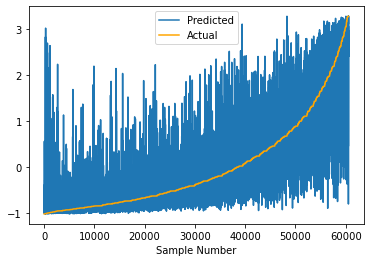

0       -0.953907
1       -0.941438
2       -0.981130
3       -0.964451
4       -0.895082
           ...   
60560    3.286299
60561    2.405610
60562    2.694839
60563    2.648305
60564    3.053846
Length: 60565, dtype: float64

In [168]:
report(valid_target, valid_features, model=foresWER3t, classifier=False, scorer=scorer)

In [169]:
valid_target.sort_values().index[:1000]

Int64Index([58160, 28305,  4338, 28482, 10346, 28526, 28584, 59866, 10288,
            46823,
            ...
            30334, 18895,  9566, 59659,  4341, 15972, 51195, 57993, 30254,
             6094],
           dtype='int64', length=1000)

In [170]:
forest_analysis = valid_df.iloc[valid_target.sort_values().index[:1000]]
forest_analysis = scaler.inverse_transform(forest_analysis[['Price', 'RegistrationYear', 'Power', 'Mileage', 'Repaired', 'UntrustedData']])
forest_analysis = pd.DataFrame(forest_analysis, columns=['Price', 'RegistrationYear', 'Power', 'Mileage', 'Repaired', 'UntrustedData'])

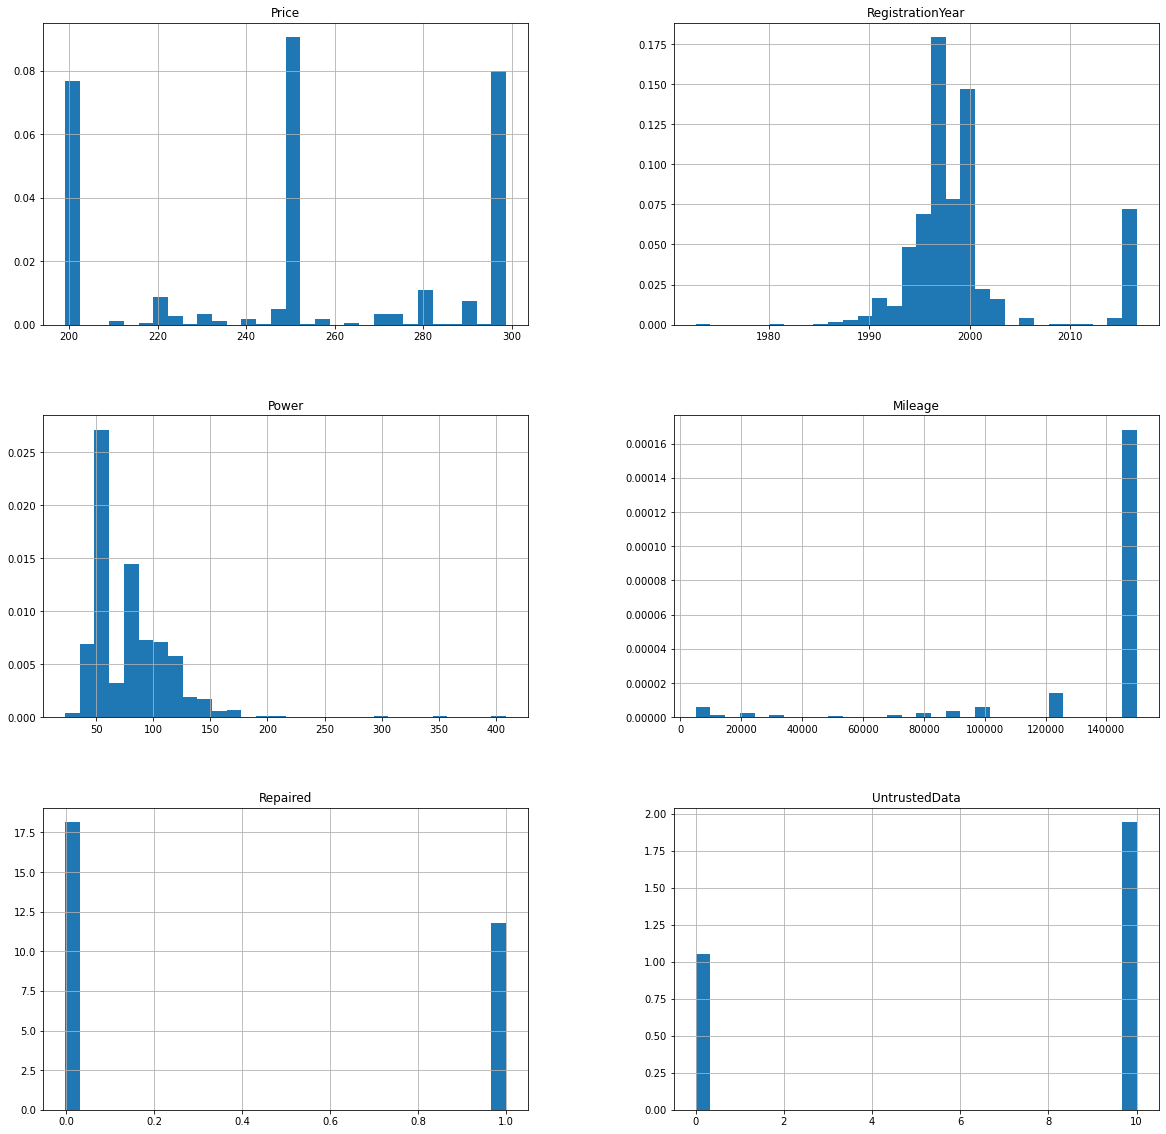

In [171]:
forest_analysis.hist(bins=30, figsize=(20,20), density=True)
plt.show()


### Results

## Conclusion